# Logistic Regression to aid in Feature Selection 

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

In [164]:
# LOADING IN TRAINING DATA 
df = pd.read_csv("data/train.csv")
# Note that y contains binary label indicating if mid_price goes up 
# in next timestep (y = 1) or not (0). Output probability of mid_price
# going up. 
df.columns = list(df.columns.values)
df_test = pd.read_csv("data/test.csv")
#df_test.columns = list(df_test.columns.values)

In [165]:
df_test.head()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid1vol,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol
0,592380,5178.4,5178.3,1.0,11.0,12.0,-10,5178.2,5178.0,5177.8,...,3,16,3,1,1,1,4,1,5,2
1,592381,5133.0,5132.9,1.0,0.0,1.0,1,5132.8,5132.6,5132.4,...,1,2,2,1,10,4,8,1,1,1
2,592382,5177.4,5178.0,2.0,0.0,2.0,2,5177.2,5176.8,5176.6,...,8,18,1,1,6,7,4,1,2,5
3,592383,5093.6,5093.9,0.0,2.0,2.0,-1,5093.2,5093.0,5092.8,...,8,5,4,3,1,1,1,11,6,2
4,592384,5189.2,5189.2,NaN,NaN,0.0,0,5188.8,5188.6,5188.4,...,1,5,1,3,3,3,2,1,3,4


In [166]:
df_num_corr = df.corr()['y'][:-1]
golden_features_list = df_num_corr[abs(df_num_corr) > 0.01].sort_values(ascending=False)
print("There are {} features decently correlated w/ mid price:\n{}".format(len(golden_features_list), golden_features_list))


There are 21 features decently correlated w/ mid price:
bid1vol                 0.086308
transacted_qty          0.056453
closed_position_qty     0.046323
opened_position_qty     0.032599
bid2vol                 0.029456
last_price              0.019276
ask5                    0.019128
ask4                    0.019119
ask3                    0.019109
ask2                    0.019092
bid4                    0.018991
bid3                    0.018990
bid5                    0.018989
bid2                    0.018984
ask1                    0.018978
mid                     0.018940
bid1                    0.018901
id                      0.014694
d_open_interest        -0.015503
ask2vol                -0.025560
ask1vol                -0.126212
Name: y, dtype: float64


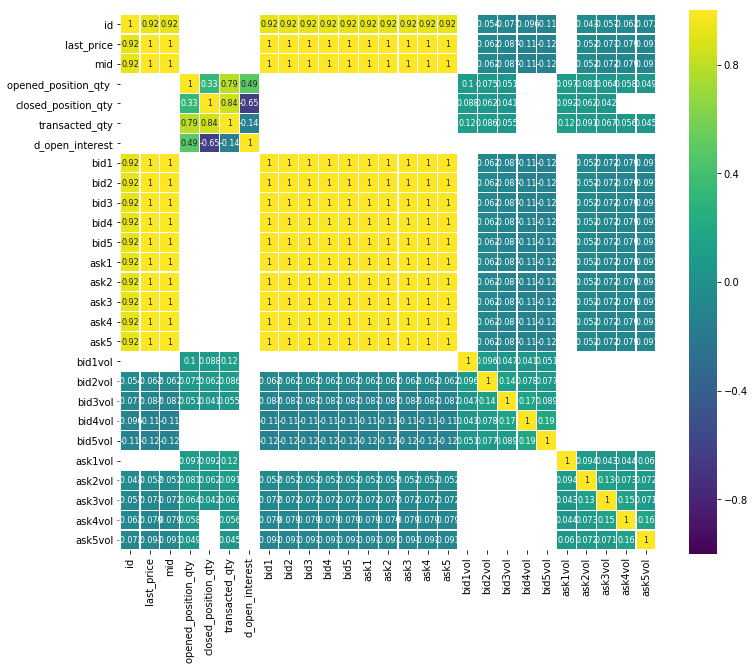

In [150]:
corr = df.drop('y', axis=1).corr() # We already examined y correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.04) | (corr <= -0.04)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Analyzing the correlation above: It looks like both mid_price and last_price are highly correlated with 
one another, and both are perfectly correlated [bid1, bid2,  ... bid5,ask1, ... ask5], which indicates that
we may want to drop many or all of [bid1, bid2,  ... bid5,ask1, ... ask5] and one of [mid_price, last_price]
to avoid extreme multicollinearity in a linear model. For non-linear, this is not so clear. 

In [167]:
# Dropping the nuisance columns 
df.drop(columns=['closed_position_qty', 'opened_position_qty '], inplace=True)
df_test.drop(columns=['closed_position_qty', 'opened_position_qty '], inplace=True)

# Let's drop [bid2, ... bid5, ask2, ... ask5] columns due to heavy correlation 
df.drop(columns=['bid2', 'bid3', 'bid4', 'bid5','ask2', 'ask3', \
                 'ask4', 'ask5'], inplace=True)
df_test.drop(columns=['bid2', 'bid3', 'bid4', 'bid5','ask2', 'ask3', \
                 'ask4', 'ask5'], inplace=True)

# the bid and ask vols seem to be not horribly correlated so let's leave em 

In [168]:
# Separating into X and y training 
last_idx = len(df.columns) - 1
X = df[df.columns[:-1]]
y_train = df[df.columns[last_idx]]
X = np.array(X)
y_train = np.array(y_train)
X_test = df_test
X_test = np.array(X_test)

In [169]:
pd.isna(X).any()

False

In [170]:
pd.isna(X_test).any()

False

In [171]:
# HANDLING IDs FOR TRAINING 
X_ids = X[:, 0]  # Vector of id's 
X = X[:, 1:]
# HANDLING IDs for TEST
X_test_ids = X_test[:, 0]
X_test = X_test[:, 1:]

In [172]:
# Normalize test set features using training set stats
for j in range(0,len(X_test[0])):
    X_std = np.std(X[:, j])
    X_test[:, j] -= np.mean(X[:, j])
    X_test[:, j] *= (1 / X_std)

# Normalize training set features 
for j in range(0,len(X[0])):
    X_std = np.std(X[:, j])
    X[:, j] -= np.mean(X[:, j])
    X[:, j] *= (1 / X_std)

In [173]:
np.isnan(X_test).any()

False

In [174]:
np.isnan(X).any()

False

# Logistic Regression w/ L2 Regularization 

In [175]:
# Let's try logistic regression for different lambda = 0.00001,
# 0.00005, 0.00025, 61, 035.15625
lam = 0.0005 # Penalizing to take care of some strong correlation between features  
# C is inverse of regularization strength 

# The C's (inv regularization strength) range from 1e-5 ... 1e5
clf = LogisticRegressionCV(cv=5, random_state=0).fit(X, y_train)
#clf = LogisticRegression(penalty='l2', C=(1/lam)).fit(X, y_trai )
y_pred = clf.predict_proba(X)
y_pred = y_pred[:,1]    # Grabbing probabililities of being in class 1

In [176]:
# Performance metric AUC (Area under the Receivor Operating Curve), you want an AUC near 1 
roc_auc_score(y_train, y_pred)
#X = preprocessing.normalize(X) # Normalizing all observation vectors to have length of 1

0.6392191120043059

In [177]:
# Predicting on test set 
y_pred_test = clf.predict_proba(X_test)
y_pred_test = y_pred_test[:,1]  

In [188]:
X_test_ids = X_test_ids.astype(int)

# Outputting results to submission csv 

In [189]:
predictions = {'id': X_test_ids, 'Predicted': y_pred_test}
df_output = pd.DataFrame(predictions, columns=['id', 'Predicted'])
df_output.set_index('id')

,Predicted
id,
592380,0.663596
592381,0.423627
592382,0.353316
592383,0.525968
592384,0.465634
592385,0.396065
592386,0.423850
592387,0.468543
592388,0.352250


In [186]:
#df_output.dtypes
#df_output.astype({'id': 'int32'}, inplace=True).dtypes

id             int32
Predicted    float64
dtype: object

In [187]:
df_output.head()

,id,Predicted
0,592380.0,0.663596
1,592381.0,0.423627
2,592382.0,0.353316
3,592383.0,0.525968
4,592384.0,0.465634


In [190]:
df_output.to_csv('logis_regularized_1.csv', index=None)

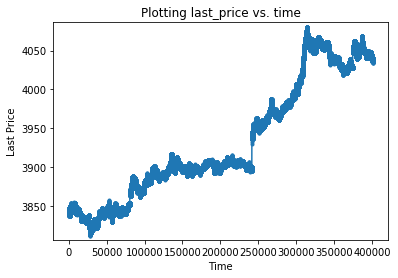

In [15]:
fig = plt.figure()
plt.title('Plotting last_price vs. time')
plt.xlabel('Time')
plt.ylabel('Last Price')
plt.margins(y=0.02)

plt.plot(train_data["id"], train_data["last_price"], marker = '.', linewidth = 1.5)

In [ ]:
# Let's try a neural net (non-linear model that is a composition of linear models)

In [ ]:
# Note that the majority of the time, the mid price does not go up. Also note that on average,
# the maximum likelihood model (e.g. Regression) gives higher probabilites to positive examples
# and lower probabilities to negative examples. 

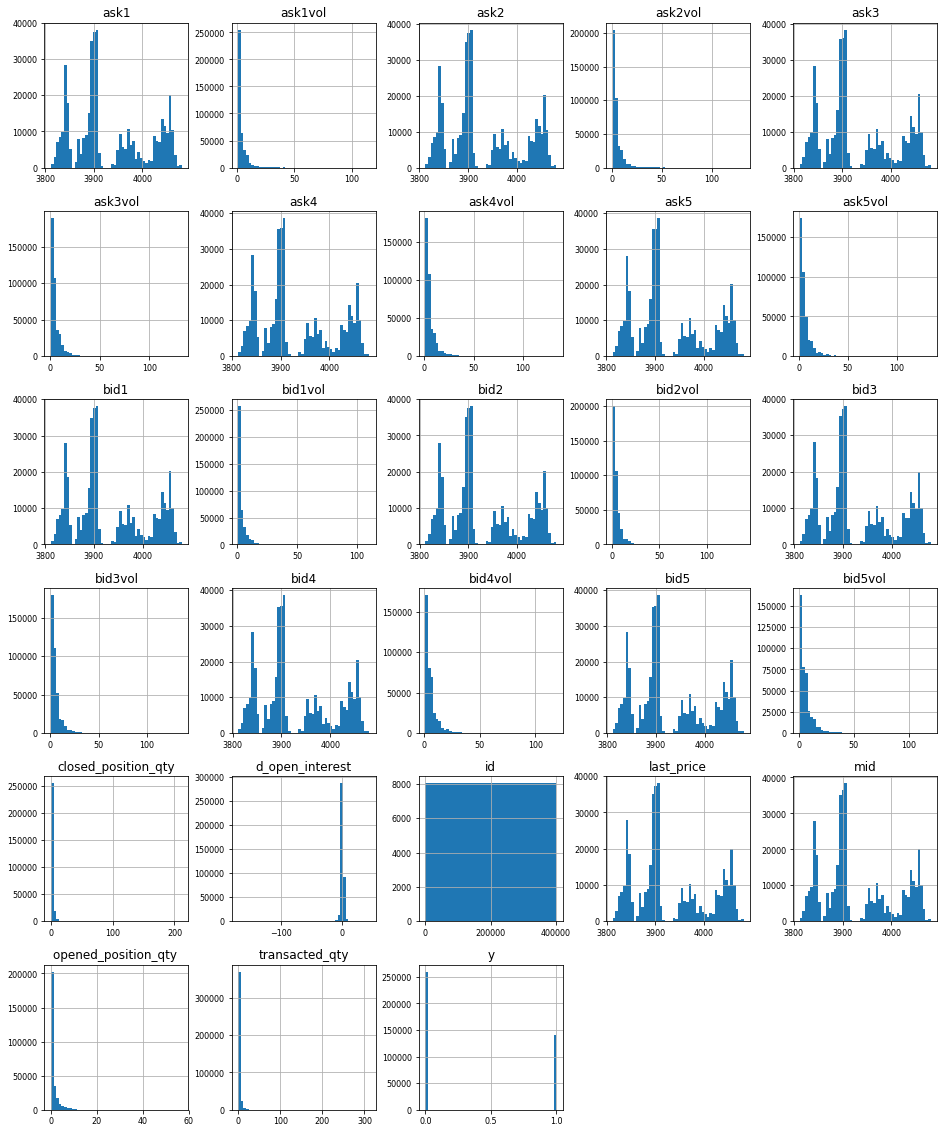

In [20]:
train_data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);
# None of these really look that Gaussian... 

In [ ]:
# Random Forest? (ensemble forest)
# SVM 
# Naive Bayes 
#data_corr = 